# Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals

This notebook illustates the section Dataset partitioning in the paper "Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals". It describes the splitting strategies adopter to train the DL-based model and their statistical validation with Kolmogorov-Smirnov (KS) test.
## Environment Setup

To execute this notebook, use the main conda environment (created using environment_main.yaml). If running in terminal activate using:

```bash
conda activate main_DE
```

## Dataset partitioning prior to MPNN model training

In the following section we will consider three strategies for splitting the data into training and test sets:

- **random splitting**: randomly split the sataset with 80:20 ratio.
- **clustering-based splitting**: dataset grouped into clusters with singletons as test set.
- **cluster-centroid splitting**: dataset grouped into clusters with centroids as training and singletons as test set.
In the second and third approach the dataset will be divided into structurally homogeneous groups using the Butina clustering algorithm.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit import DataStructs
from rdkit.Chem import Fragments, rdMolDescriptors, rdchem, MCS, rdFingerprintGenerator, Descriptors
from rdkit.ML.Cluster import Butina

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
startPBT_correct = pd.read_csv('Datasets/5130compounds_PBT.csv')
startPBT_correct

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


### **Generating fingerprints**

In [3]:
compounds = []
none_indices = []

for index, smiles in startPBT_correct[['standardized_smiles']].itertuples():
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        none_indices.append(index)
    else:
        compounds.append(mol)

In [4]:
fps = []
for smiles in startPBT_correct['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        fps.append(fingerprints)
#fps

In [5]:
len(fps)

5130

### **Tanimoto similarity and distance matrix**

Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids. For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [6]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [7]:
#Calculate single similarity of two fingerprints
sim = DataStructs.TanimotoSimilarity(fps[0], fps[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.02, distance: 0.98


In [8]:
#Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fps)[0:5]

[0.9849624060150376,
 0.9805194805194806,
 0.9714285714285714,
 0.9817073170731707,
 0.9523809523809523]

### **Clustering molecules**
In this part, we cluster the molecules and look at the results.

Define a clustering function.

In [9]:
def cluster_fingerprints(fps, cutoff=0.4):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fps), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Cluster the molecules based on their fingerprint similarity.

In [10]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fps, cutoff=0.4)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  1650
# clusters with only 1 compound:  1066
# clusters with >5 compounds:  164
# clusters with >25 compounds:  24
# clusters with >100 compounds:  2


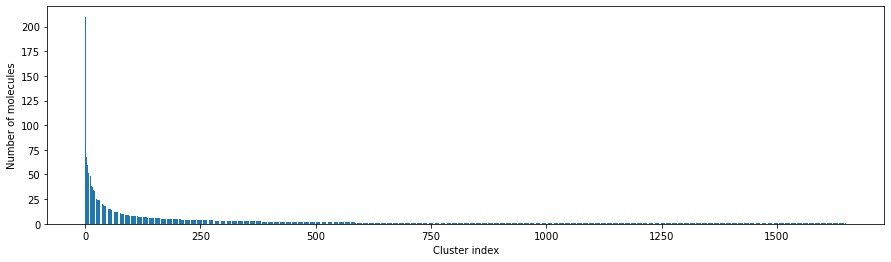

In [11]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

#### **Visualizing the clusters**
10 examples from largest cluster¶
Now, let’s have a closer look at the first 10 molecular structures of the first/largest clusters.

In [12]:
# Assuming 'clusters' is a list of lists, where each sublist is a cluster
singleton_clusters = [c for c in clusters if len(c) == 1]
non_singleton_clusters = [c for c in clusters if len(c) > 1]

# If you need to extract the cluster centers, you would need additional information
# about how the clusters were formed. Typically, the first or the most central
# compound could be considered the 'center'. This is a simplistic approach:
cluster_centers = [c[0] for c in non_singleton_clusters]  # Taking the first element as the center

print("total # clusters: ", len(clusters))
print("# singleton clusters: ", len(singleton_clusters))
print("# non-singleton clusters: ", len(non_singleton_clusters))

# If you need to do something with the singleton clusters or the cluster centers, you can now do so.

total # clusters:  1650
# singleton clusters:  1066
# non-singleton clusters:  584


In [13]:
len(cluster_centers)

584

In [14]:
# If 'molecules' is a list where the index corresponds to the molecule:
singleton_molecules = [compounds[c[0]] for c in singleton_clusters]
non_singleton_centres = [[compounds[i] for i in c] for c in non_singleton_clusters]

In [15]:
len(singleton_molecules)

1066

In [16]:
# Flatten the list of non-singleton clusters to get all molecule indices or identifiers in non-singleton clusters
non_singleton_molecule_ids = [id for cluster in non_singleton_clusters for id in cluster]

non_singleton_molecules = [compounds[id] for id in non_singleton_molecule_ids]

In [17]:
len(non_singleton_molecules)

4064

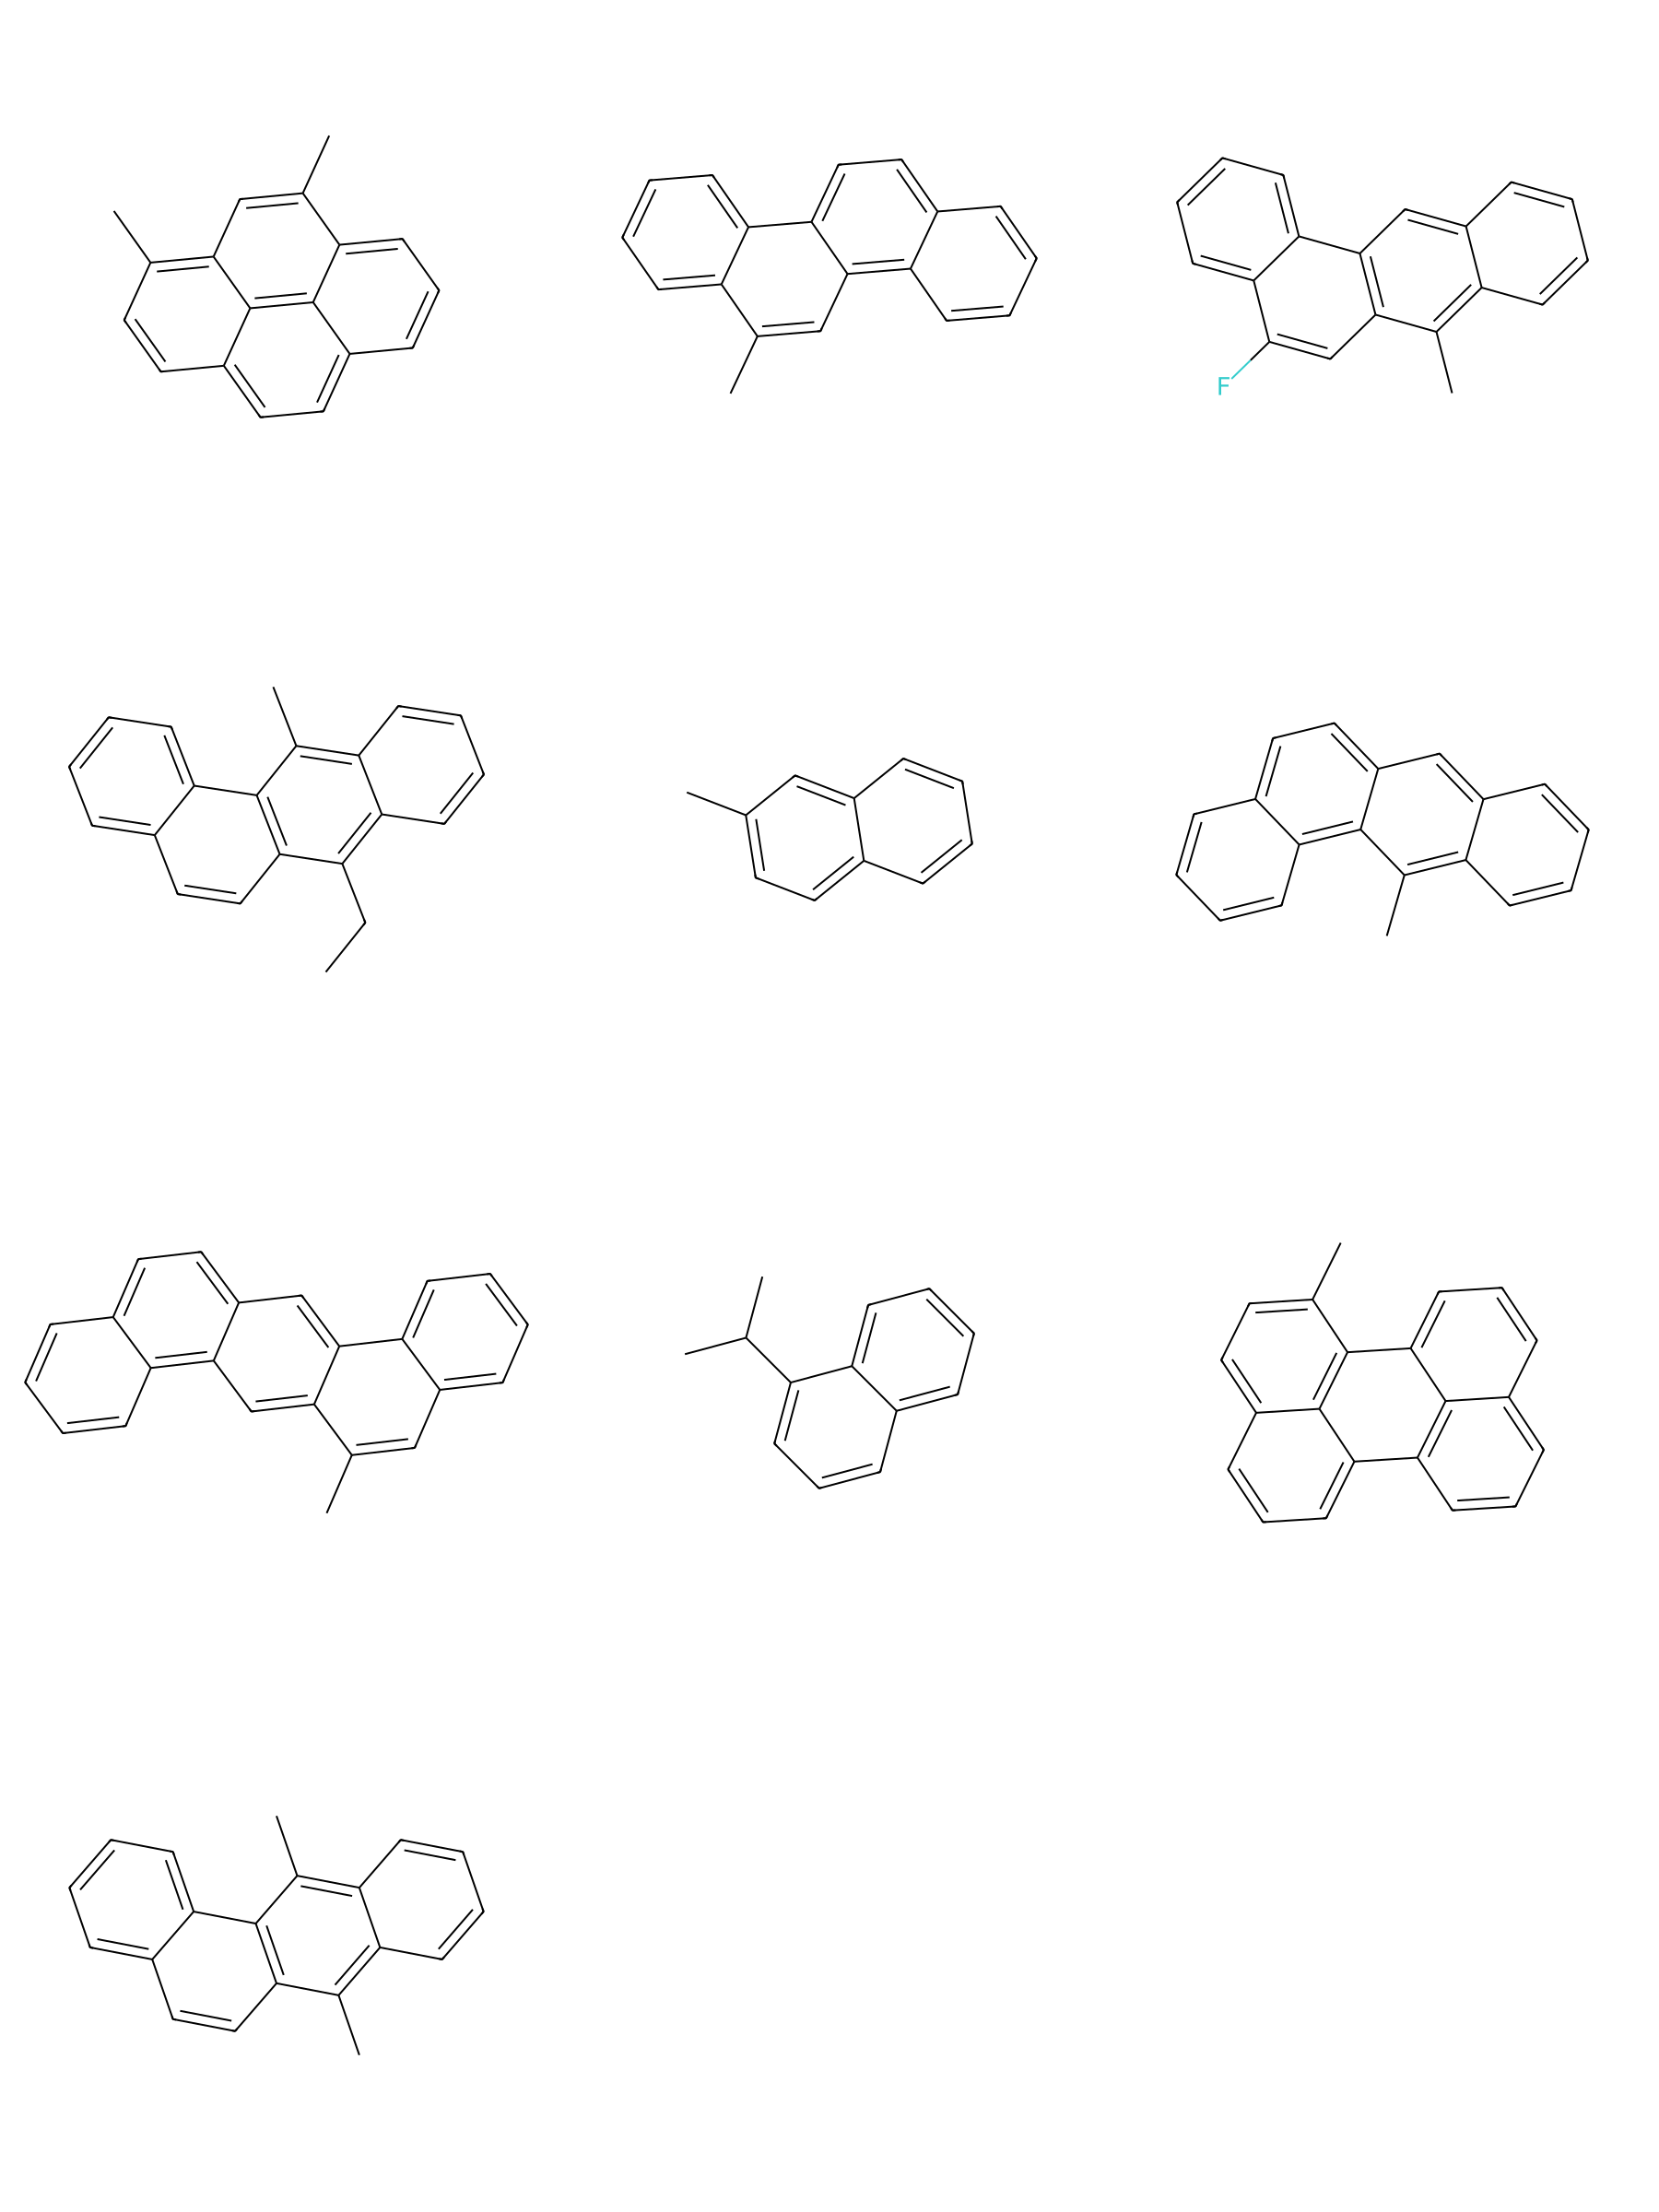

In [18]:
# Get the first 10 molecules from the largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[1][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

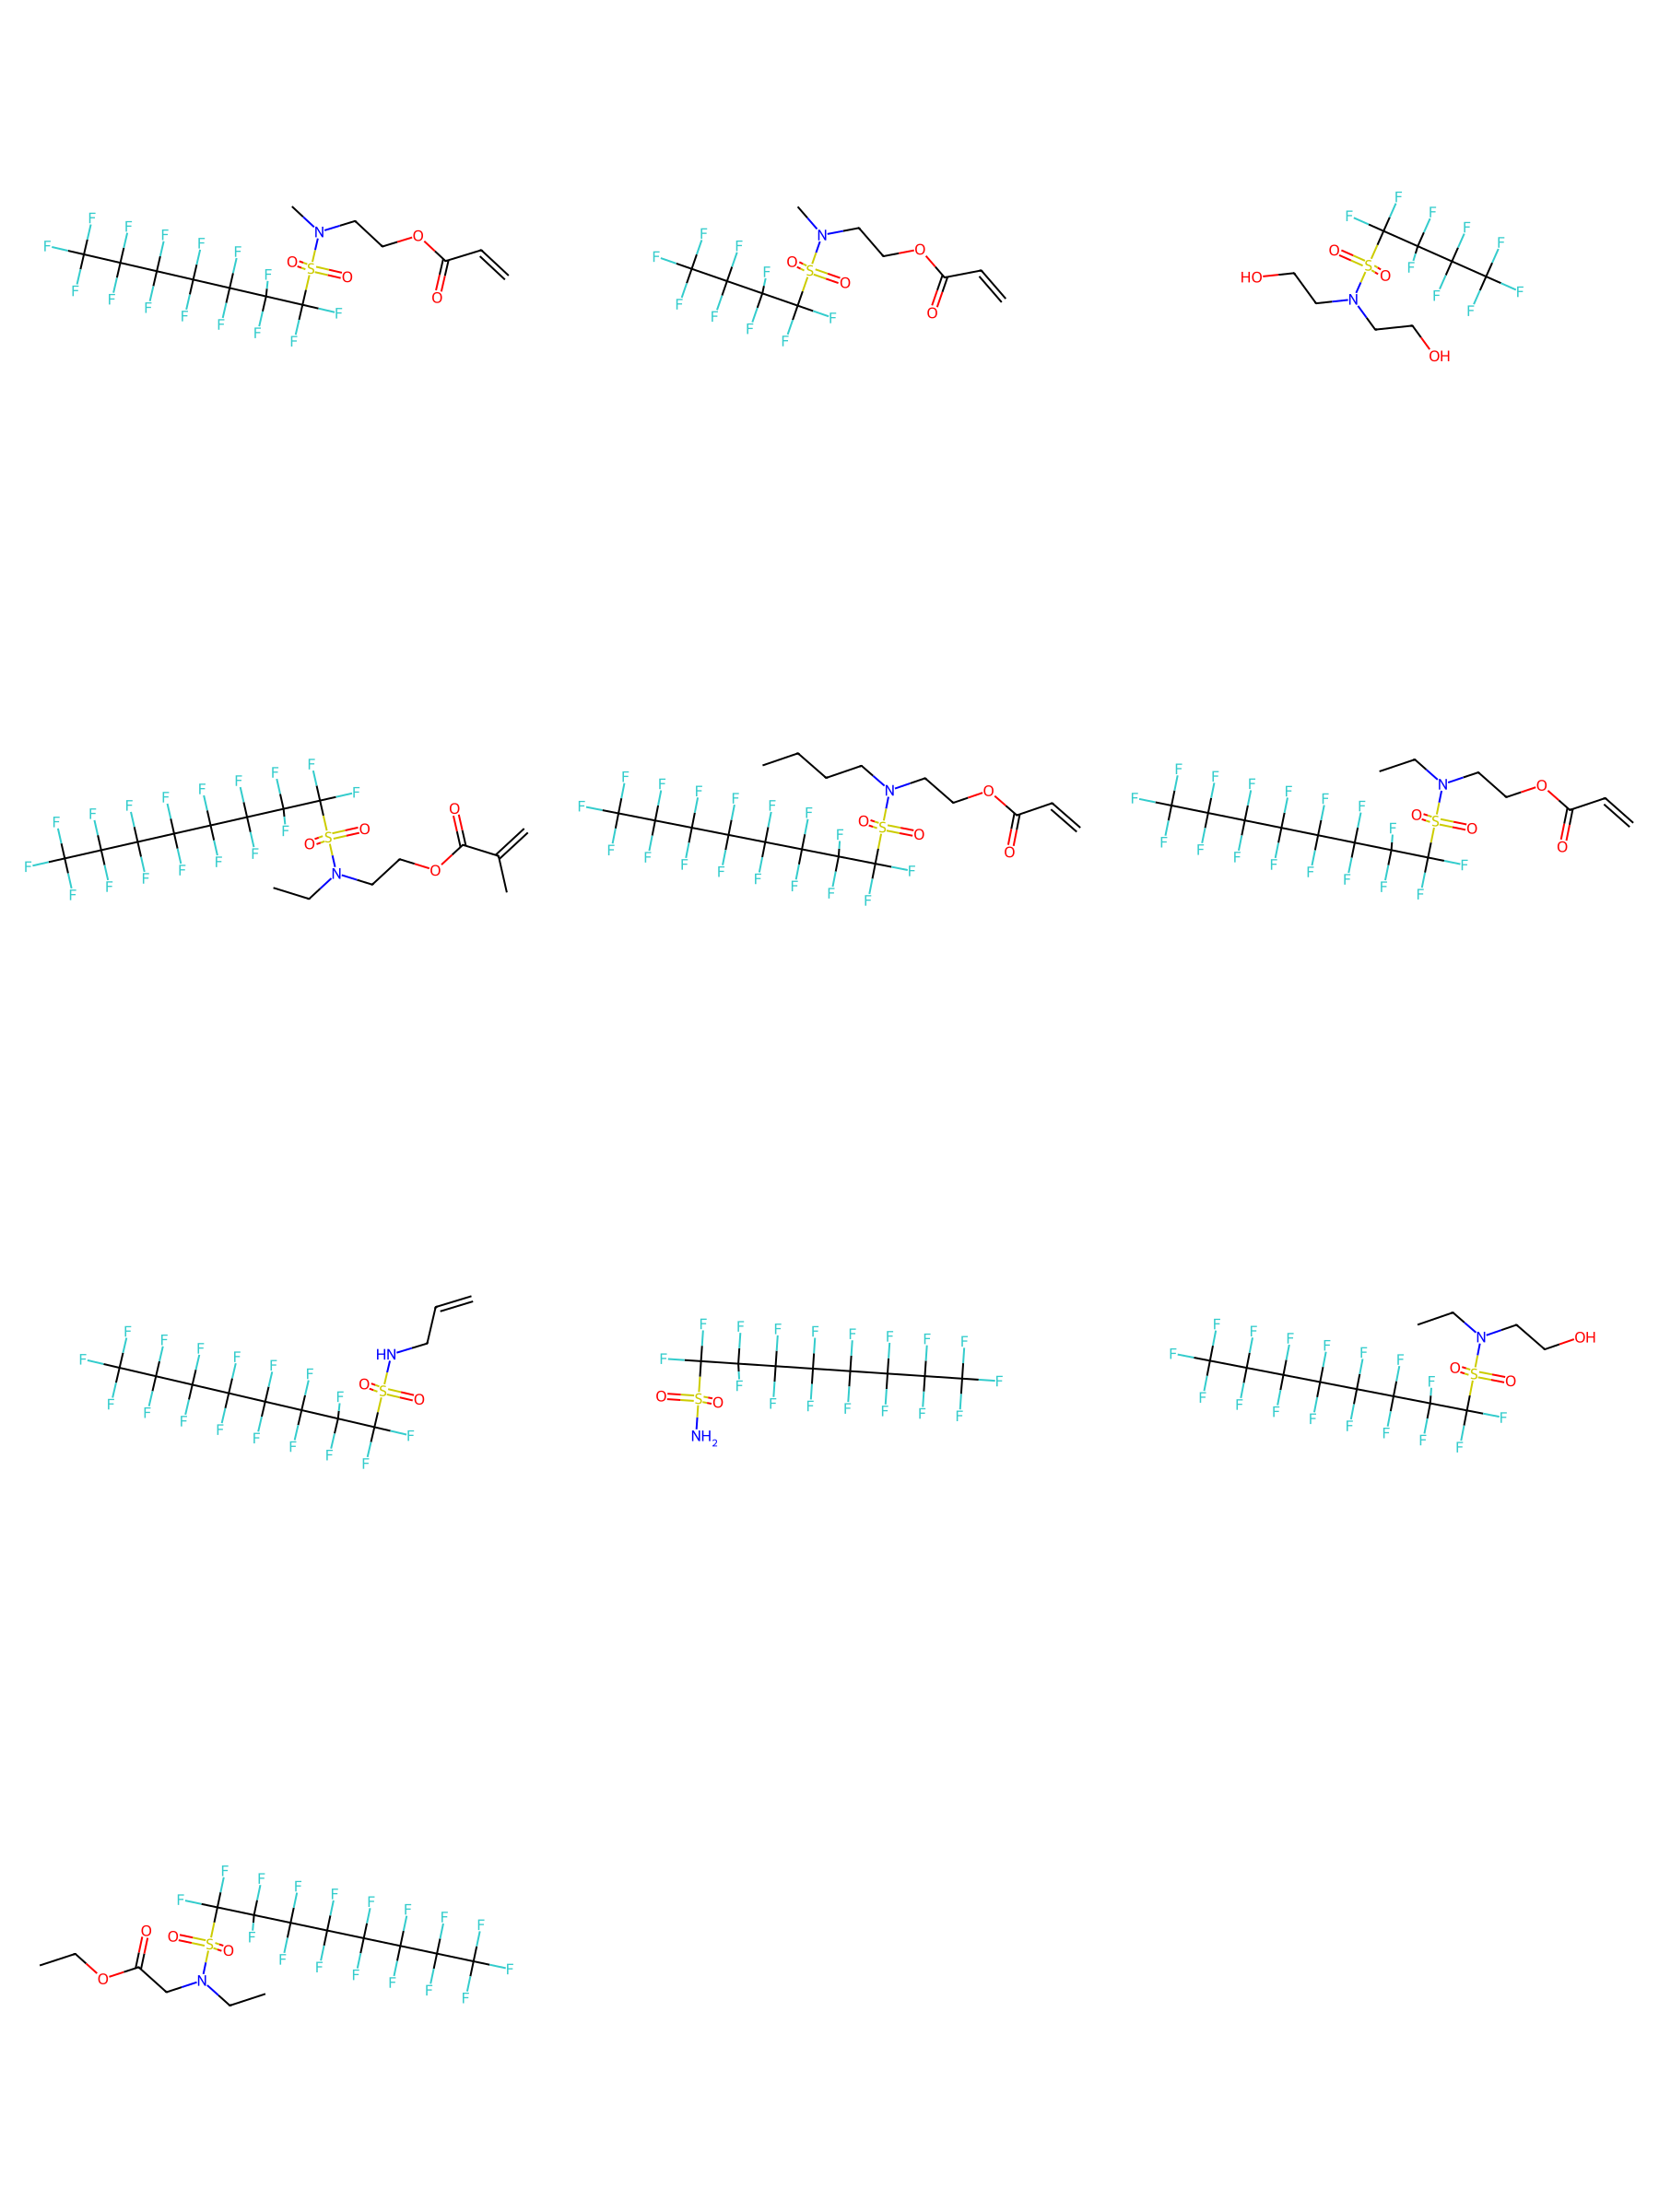

In [19]:
# Get the first 10 molecules from the second largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[2][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

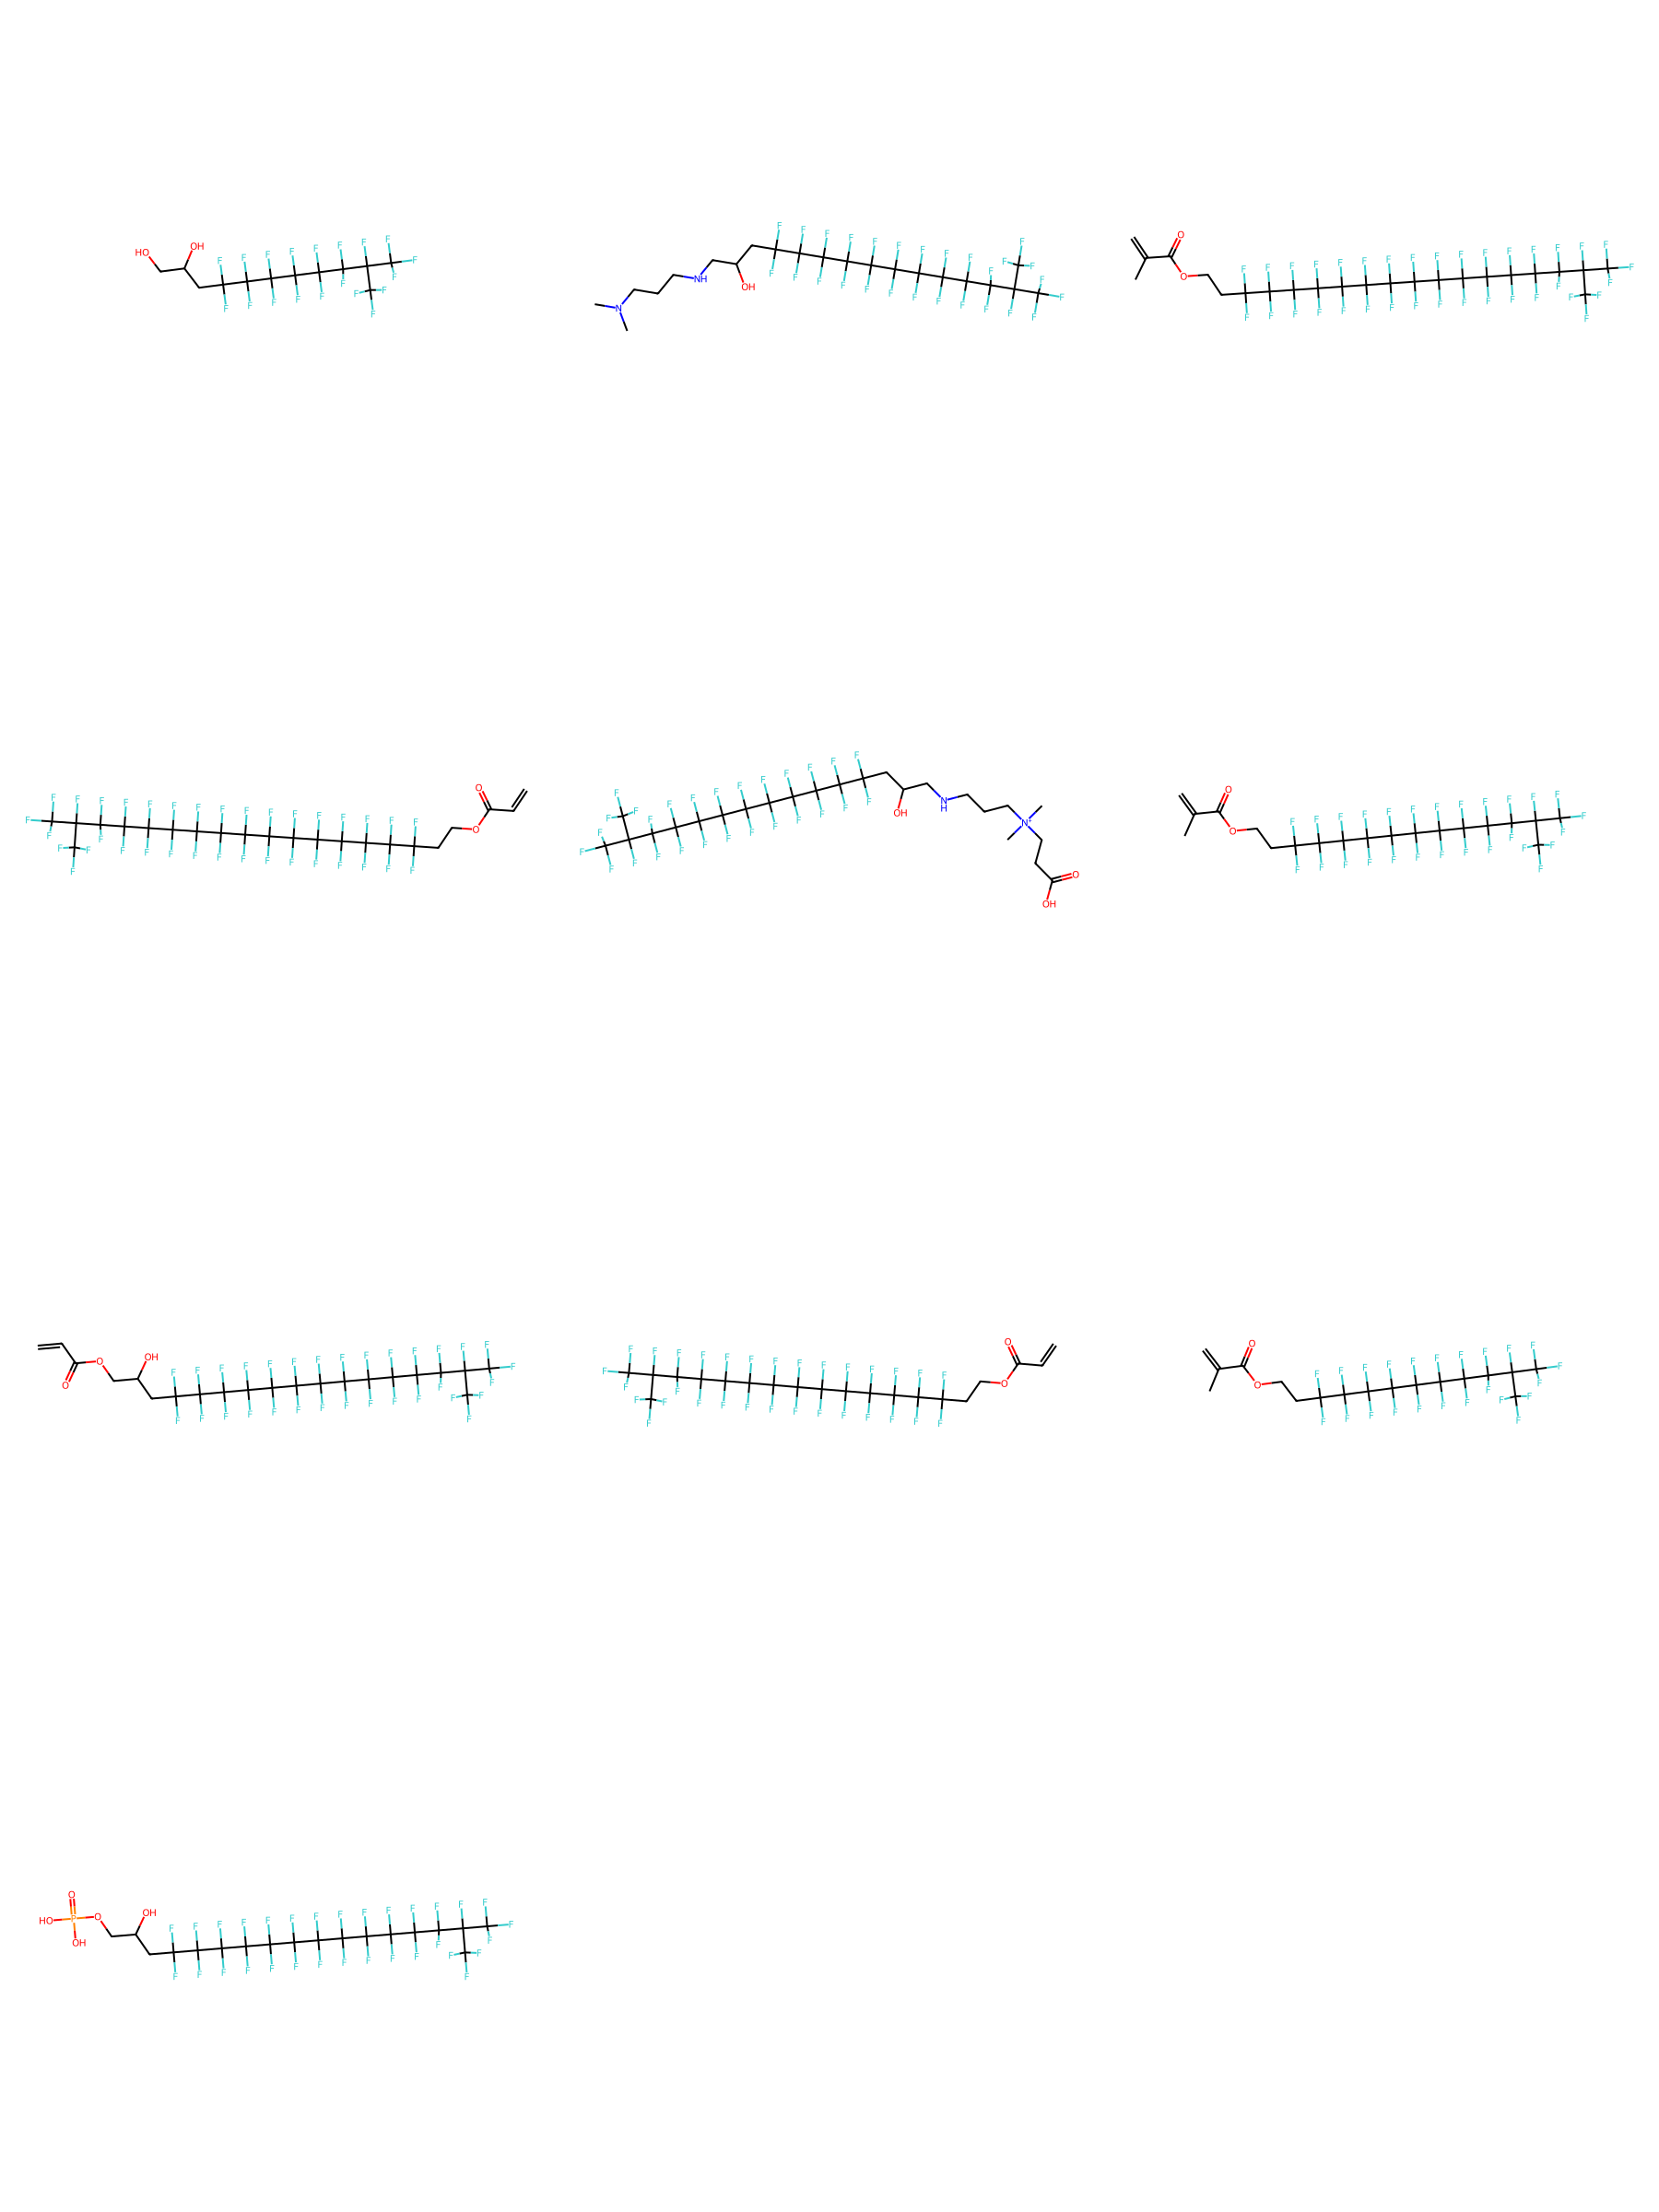

In [20]:
# Get the first 10 molecules from the third largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[3][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

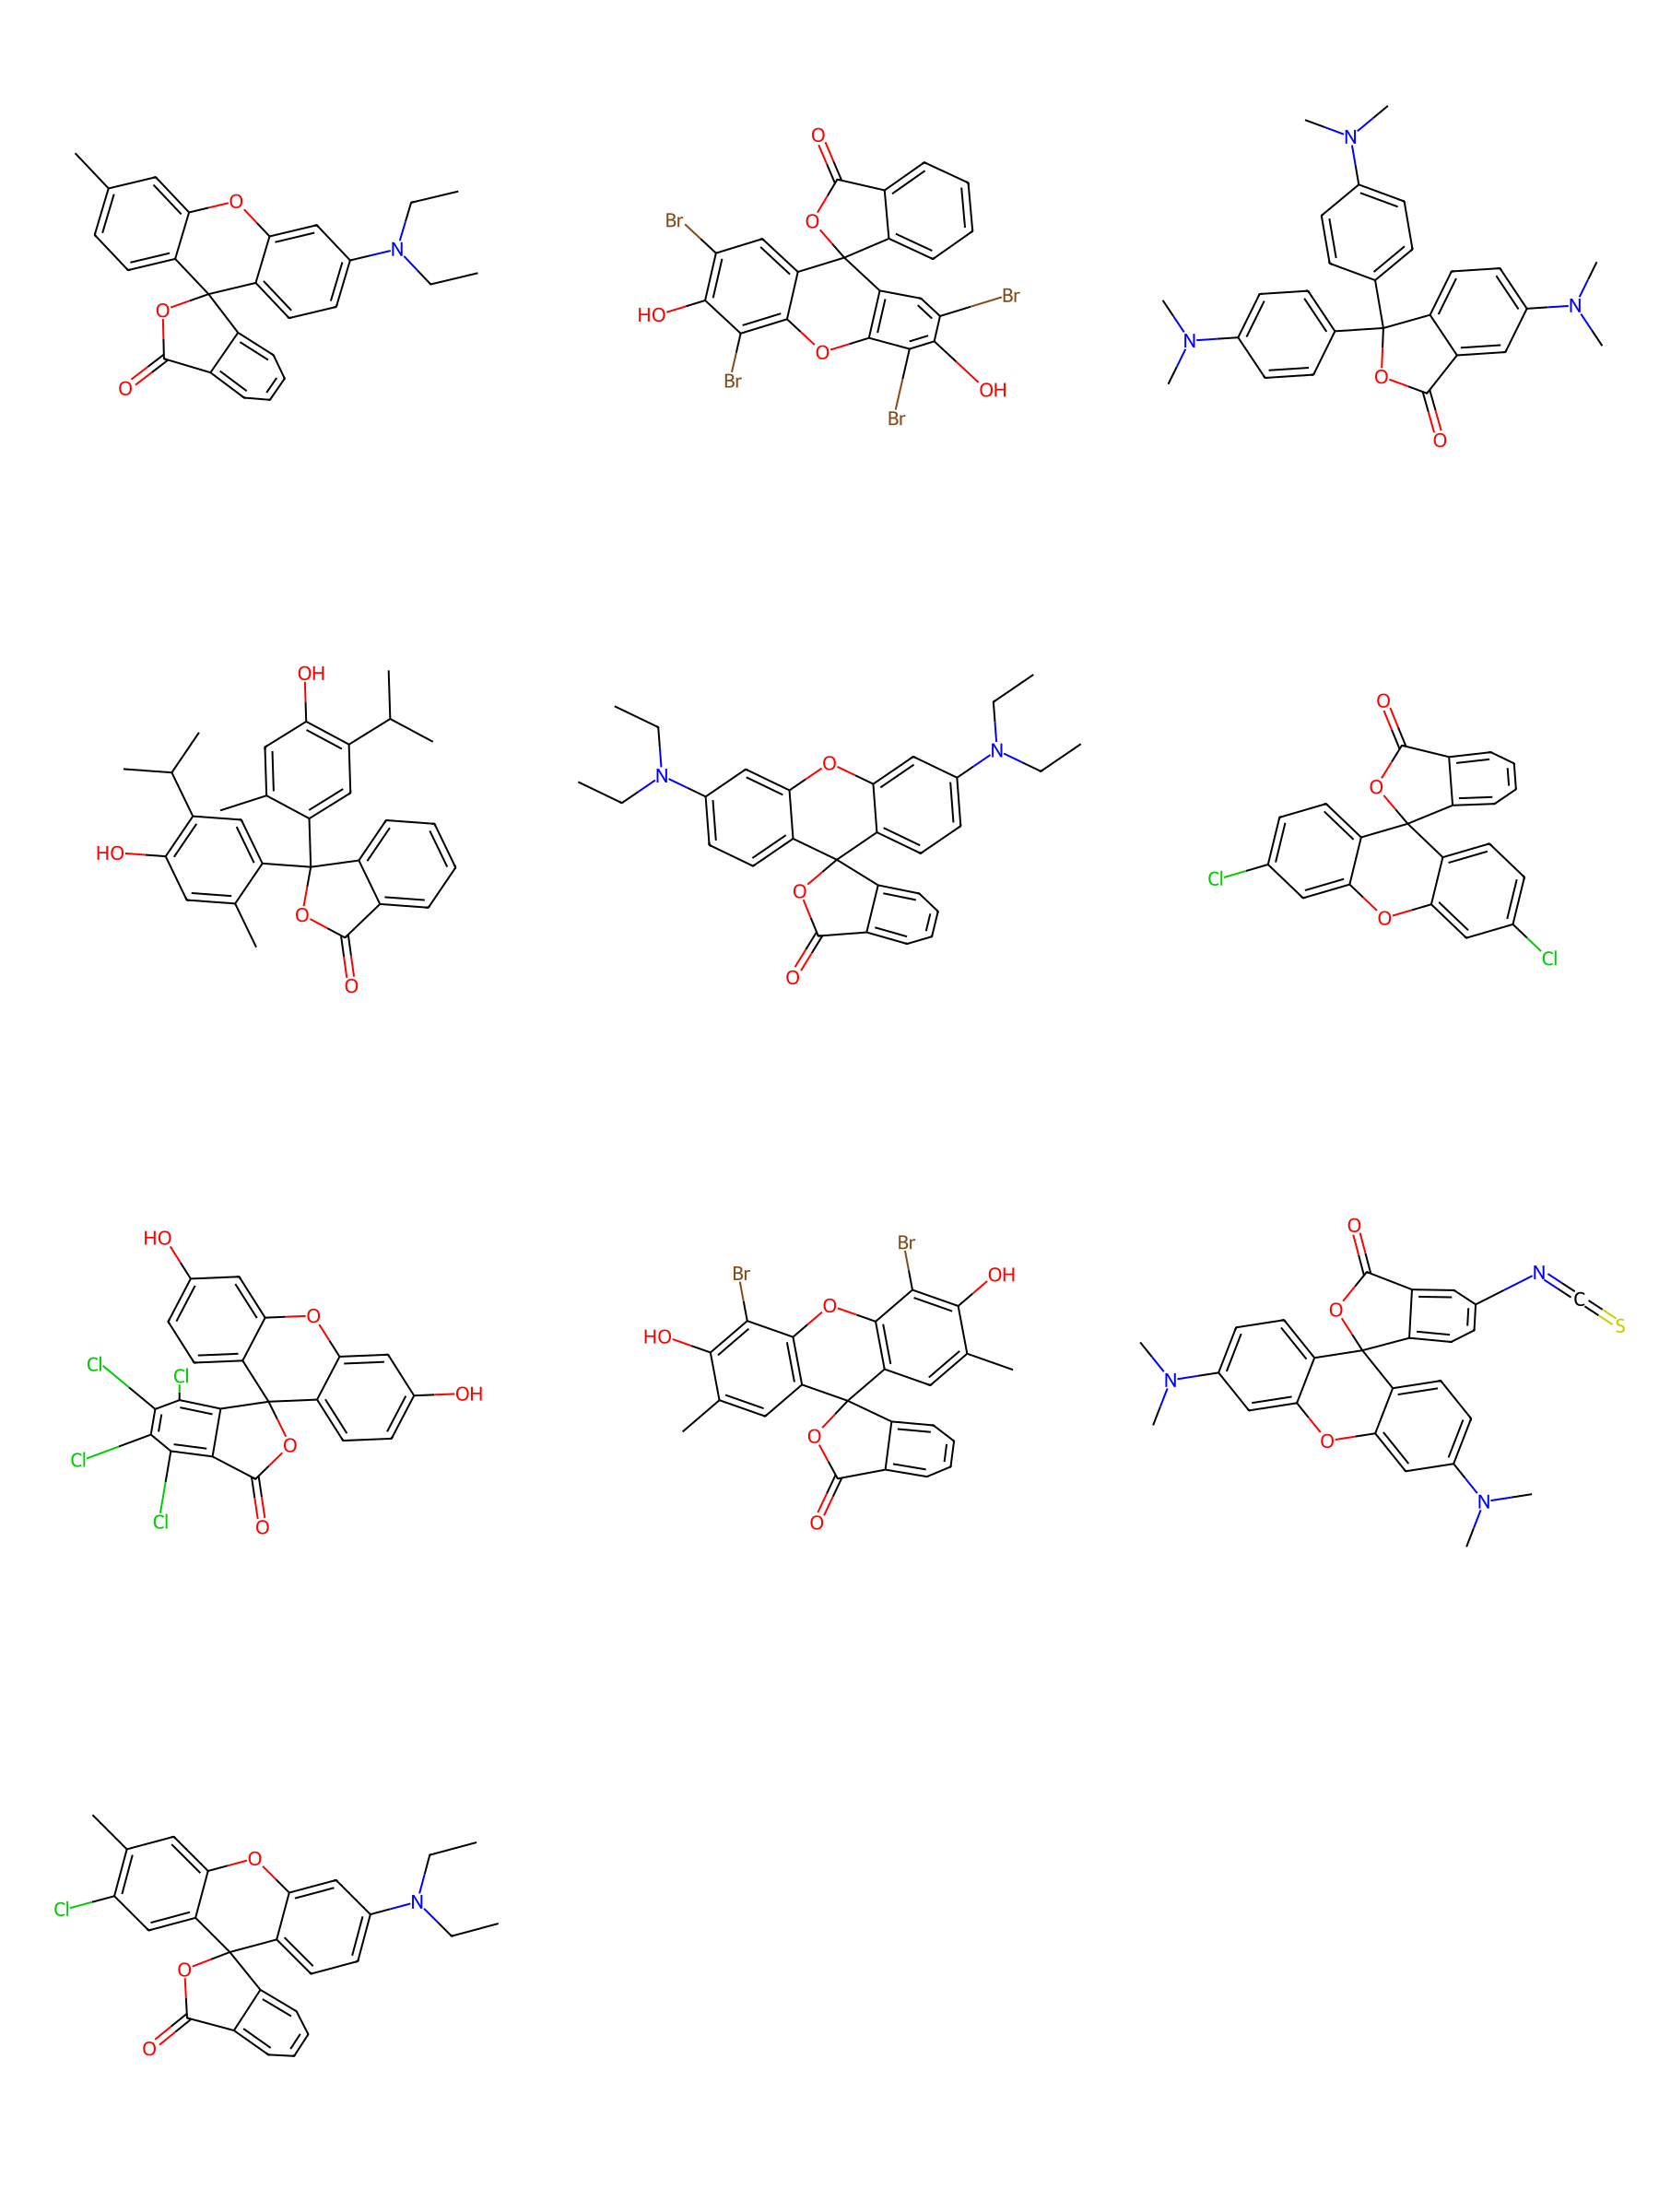

In [21]:
# Get the first 10 molecules from the fourth largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[4][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

#### **Intra-cluster Tanimoto similarities fon non_singleton_molecules**
We can also have a look at the intra-cluster Tanimoto similarities.

In [22]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [23]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in non_singleton_clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


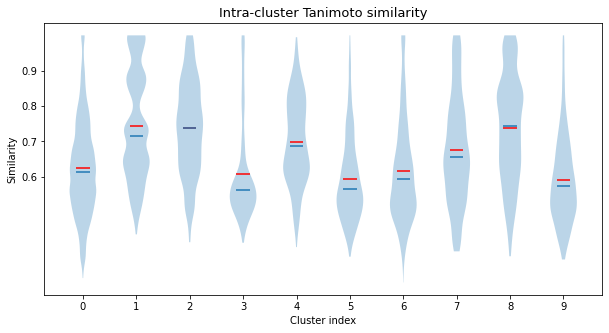

In [24]:
# Violin plot with intra-cluster similarity
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

#### **Building new Training set for Clustering splitting**

In [25]:
# Convert mol objects to SMILES strings
training_smiles_list = [Chem.MolToSmiles(mol) for mol in non_singleton_molecules]
# Convert list to DataFrame
df = pd.DataFrame(training_smiles_list, columns=['SMILES'])
df

,SMILES
0,O=C1CCCCCO1
1,CCCCCCCCCCCCCCCCCC(=O)O
2,CCCCCCCCCC(=O)O
3,CCCCCCCCCCCCCCCCCCCCCC(=O)O
4,O=C(O)CCCCC(=O)O
...,...
4059,O=P(O)(O)O
4060,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...
4061,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...
4062,FC(F)CC(F)(F)F


In [26]:
training_dat = startPBT_correct[startPBT_correct['standardized_smiles'].isin(df['SMILES'])]
training_dat

,standardized_smiles,PBT_label
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
5,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
6,CC(O)C(=O)O,0
7,Cc1ccccc1Cl,0
...,...,...
5124,CN(C)CCCCCCN(C)C,0
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [27]:
# Count 1s and 0s in the second column
count_1s = training_dat['PBT_label'].value_counts().get(1, 0)
count_0s = training_dat['PBT_label'].value_counts().get(0, 0)

print(f'Number of 1s: {count_1s}')
print(f'Number of 0s: {count_0s}')

Number of 1s: 2271
Number of 0s: 1793


In [28]:
training_dat.to_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv', index = False)

#### **Building new test set for Clustering splitting**

In [29]:
# Convert mol objects to SMILES strings
test_smiles_list = [Chem.MolToSmiles(mol) for mol in singleton_molecules]
# Convert list to DataFrame
df = pd.DataFrame(test_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCCCC(CC)COC(=O)CS
1,CCOC(=O)CC(C(C)=O)C(=O)OCC
2,CCCCCCC(O)CC=CCCCCCCCC(=O)OC
3,CC(C)=CCN1CCC23CCCCC2C1Cc1ccc(OC(=O)c2cccnc2)cc13
4,CC(=O)OCCC(C)OC(C)=O
...,...
1061,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1
1062,O=S(=O)(O)C(F)(F)F
1063,S=c1[nH]c2ccccc2s1
1064,C=C(F)C(=O)OC


In [30]:
# Filter df_cross_PBT for only rows with common_elements
singletons = startPBT_correct[startPBT_correct['standardized_smiles'].isin(df['SMILES'])]
singletons

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
4,S=c1[nH]c2ccccc2s1,0
10,O=S(=O)(O)C(F)(F)F,0
30,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
5109,NCCCN1CCN(CCCN)CC1,0
5110,CC(=O)NNC(C)=O,0
5111,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
5116,C=CC(=O)NCNC(=O)C=C,0


In [31]:
singletons.to_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv', index = False)

#### **Building second new Training set with only cluster centres for Cluster-centroids splitting**

In [32]:
cluster_centres_mol = [compounds[c[0]] for c in non_singleton_clusters]

In [33]:
len(cluster_centres_mol)

584

In [34]:
# Convert mol objects to SMILES strings
training_smiles_list = [Chem.MolToSmiles(mol) for mol in cluster_centres_mol]
# Convert list to DataFrame
df_train = pd.DataFrame(training_smiles_list, columns=['SMILES'])
df_train

,SMILES
0,O=C1CCCCCO1
1,Cc1cc2c(C)ccc3ccc4cccc1c4c32
2,C=CC(=O)OCCN(C)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C...
3,OCC(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...
4,CCN(CC)c1ccc2c(c1)Oc1cc(C)ccc1C21OC(=O)c2ccccc21
...,...
579,CCN(CC)c1ccc2cc(-c3nc4ccccc4[nH]3)c(=O)oc2c1
580,FC(F)Cl
581,O=[P+]([O-])[O-]
582,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...


In [35]:
cluster_centroids = startPBT_correct[startPBT_correct['standardized_smiles'].isin(df_train['SMILES'])]
cluster_centroids

,standardized_smiles,PBT_label
3,Clc1ccc2c(Cl)ccnc2c1,0
12,NC(=Nc1ccccc1)Nc1ccccc1,0
28,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
58,COC(=O)C(F)(F)F,0
64,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
5089,CC(C)C(NC(N)=O)NC(N)=O,0
5094,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
5101,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
5102,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [36]:
cluster_centroids.to_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv', index= False)

### **Split Data**
#### **Random Splitting**

In [37]:
startPBT_correct

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [38]:
# Split the data into training and test sets (80:20)
train_random_df, test_random_df = train_test_split(startPBT_correct, test_size=0.2, random_state=42)

# Save the split datasets
train_random_df.to_csv('Splitting_strategy_datasets/new_train2_random_data.csv', index=False)
test_random_df.to_csv('Splitting_strategy_datasets/new_test2_random_data.csv', index=False)

In [39]:
df_randomsplit_train = pd.read_csv('Splitting_strategy_datasets/new_train2_random_data.csv')
df_randomsplit_train

,standardized_smiles,PBT_label
0,CCCN(CCC)c1ccc(-c2nc(-c3ccc(N(C)C)cc3)c(-c3ccc...,1
1,C=CC(=O)OCCCCO,0
2,CC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C3CCC2(C)OC(C)...,1
3,CCCCOCC1CO1,0
4,CCCCCCCCCCCCCCCCOC(=O)C=CC(=O)O,0
...,...,...
4099,CCCCCCCCCCCCCCCCCC[Si](C)(C)Cl,0
4100,O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
4101,O=C(O)C(F)(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(...,1
4102,c1ccc(C2=NCCN2)cc1,0


In [40]:
random_train_fps = []
for smiles in df_randomsplit_train['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        random_train_fps.append(fingerprints)
#random_train_fps

In [41]:
len(random_train_fps)

4104

In [42]:
df_randomsplit_test = pd.read_csv('Splitting_strategy_datasets/new_test2_random_data.csv')
df_randomsplit_test

,standardized_smiles,PBT_label
0,CC(CC(C)C)=NCCNCCN=C(C)CC(C)C,0
1,CC(C)c1cccc2cc3c(ccc4ccccc43)cc12,1
2,CCCCCCCCC=CCCCCCCCC(=O)NCC(C)OC(=O)CC(C(=O)O)S...,0
3,CC(=O)OC1CCC2(C)C(CCC3C2CC(=O)C2(C)C3CC3OC4(CC...,1
4,Oc1c(Br)cc(Cc2cc(Br)c(O)c(Br)c2)cc1Br,1
...,...,...
1021,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
1022,Cc1ccc(Nc2nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n2)cc1,1
1023,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)Br,1
1024,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,1


In [43]:
random_test_fps = []
for smiles in df_randomsplit_test['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        random_test_fps.append(fingerprints)
#random_test_fps

In [44]:
len(random_test_fps)

1026

In [45]:
all_sim = []  
max_sim = []  

for train_fp in random_train_fps:
    for test_fp in random_test_fps:
        similarity = DataStructs.TanimotoSimilarity(train_fp, test_fp)
        max_sim.append(similarity)  
    all_sim.append(max(max_sim)) 
    max_sim = [] 

In [46]:
len(all_sim)

4104

#### **Clustering splitting**

Here, the test set only encompassed singletons, i.e. molecules that were the only member of their clusters; all other, non-singleton molecules were included in the training set (train: 4064 chemicals, test: 1065). 

In [47]:
Clustering_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv')
Clustering_trainmol

,standardized_smiles,PBT_label
0,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
1,Clc1ccc2c(Cl)ccnc2c1,0
2,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
3,CC(O)C(=O)O,0
4,Cc1ccccc1Cl,0
...,...,...
4059,CN(C)CCCCCCN(C)C,0
4060,CN(C)CCCN(C)C,0
4061,C[N+](C)(C)C1CCCCC1,0
4062,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [48]:
cluster_train_fps = []
for smiles in Clustering_trainmol['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        cluster_train_fps.append(fingerprints)
#cluster_train_fps

In [49]:
len(cluster_train_fps)

4064

In [50]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


In [51]:
singleton_test_fps = []
for smiles in singleton_testmol['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        singleton_test_fps.append(fingerprints)
#singleton_test_fps

In [52]:
all_sim_cs = []  # List to hold the maximum similarity for each fingerprint in non_sing_fps
max_sim_cs = []  # Temporary list to hold similarities for the current non_sing_fp against all sing_fps

for cluster_fp in cluster_train_fps:
    for sing_fp in singleton_test_fps:
        similarity = DataStructs.TanimotoSimilarity(cluster_fp, sing_fp)
        max_sim_cs.append(similarity)  # Add the similarity to the temporary list
    if max_sim_cs:  # Check if max_sim_cs is not empty
        all_sim_cs.append(max(max_sim_cs))  # Find the maximum similarity for the current non_sing_fp and add it to all_sim_cs
    else:
        all_sim_cs.append(0)  # Append a default value if max_sim_cs is empty (e.g., 0 or None)
    max_sim_cs = []  # Reset the temporary list for the next non_sing_fp

# Now, all_sim_cs contains the maximum similarity each fingerprint in non_sing_fps has with any fingerprint in sing_fps


In [53]:
len(all_sim_cs)

4064

#### **Cluster-centroids splitting**

Last, to test our approach, we only considered **cluster centroids**, i.e. a single representative molecule from each cluster, for the training set and singletons in the test set (train: 586 centroids, test: 1062).

In [54]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,standardized_smiles,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [55]:
centres_train_fps = []
for smiles in Centres_trainmol['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        centres_train_fps.append(fingerprints)
#centres_train_fps

In [56]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


In [57]:
singleton_test_fps = []
for smiles in singleton_testmol['standardized_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        singleton_test_fps.append(fingerprints)
#singleton_test_fps

In [58]:
all_sim_cc = []  # List to hold the maximum similarity for each fingerprint in non_sing_fps
max_sim_cc = []  # Temporary list to hold similarities for the current non_sing_fp against all sing_fps

for centres_fp in centres_train_fps:
    for sing_fp in singleton_test_fps:
        similarity = DataStructs.TanimotoSimilarity(centres_fp, sing_fp)
        max_sim_cc.append(similarity)  # Add the similarity to the temporary list
    if max_sim_cc:  # Check if max_sim_cs is not empty
        all_sim_cc.append(max(max_sim_cc))  # Find the maximum similarity for the current non_sing_fp and add it to all_sim_cs
    else:
        all_sim_cc.append(0)  # Append a default value if max_sim_cs is empty (e.g., 0 or None)
    max_sim_cc = []  # Reset the temporary list for the next non_sing_fp


In [59]:
len(all_sim_cc)

584

### **Figure 3: Boxplot of Tanimoto similarities between training and test sets for different data splitting strategies**
Boxplot displaying the distribution of maximum Tanimoto similarities between training and test sets for different data splitting strategies: random (orange box), clustering (yellow box) and cluster-centroids (green box) splitting. 

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/seaborn/categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(

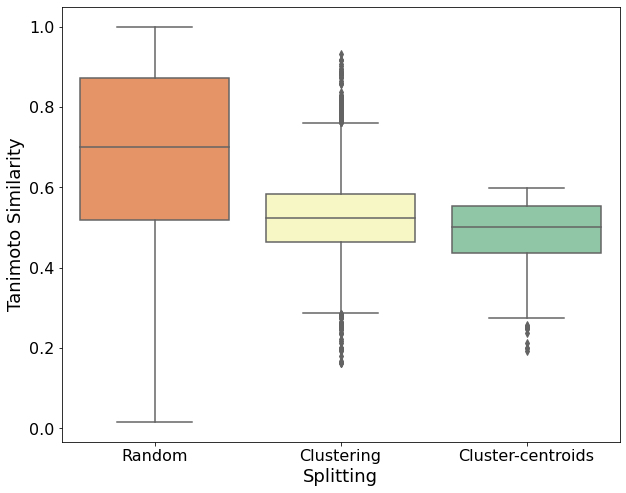

In [60]:
data = {
    'Tanimoto Similarity': all_sim + all_sim_cs + all_sim_cc,
    'Splitting': ['Random'] * len(all_sim) + ['Clustering'] * len(all_sim_cs) + ['Cluster-centroids'] * len(all_sim_cc)
}

df = pd.DataFrame(data)

# Create the box plot with specified colors
plt.figure(figsize=(10, 8))
sns.boxplot(x='Splitting', y='Tanimoto Similarity', data=df, palette='Spectral')
sns.set(style="darkgrid")
plt.xticks(rotation=0, fontsize = 18)  # Rotate labels to avoid overlap
plt.xlabel('Splitting', fontsize=18)
plt.ylabel('Tanimoto Similarity', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
bbox_props = dict(boxstyle="round,pad=0.3", ec="black", fc="white", alpha=0.7)

#plt.savefig('images/new_boxplot.png', dpi=300, bbox_inches='tight' )
plt.show()

#### **Median Similarities** 

In [61]:
np.median(all_sim)

0.7010420023633044

In [62]:
np.median(all_sim_cs)

0.5248276334413954

In [63]:
np.median(all_sim_cc)

0.5

#### **% of maxumum Tanimoto similarities above a cut-off value of 0.6**

Considering a Tanimoto similarity value of 0.6 as indicative of structural contiguity, we also added the percentage of maximum similarities that were above the cut-off value for each splitting method.

#### **Random Splitting**

In [64]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff = [sim for sim in all_sim if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff = len(maxsim_above_cutoff)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff = (num_maxsim_above_cutoff / len(all_sim)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff:.2f}%")

Number of similarities above 0.6: 2666
Percentage of similarities above 0.6: 64.96%


#### **Clustering splitting**

In [65]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff_cs = [sim for sim in all_sim_cs if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff_cs = len(maxsim_above_cutoff_cs)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff_cs = (num_maxsim_above_cutoff_cs / len(all_sim_cs)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff_cs}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff_cs:.2f}%")

Number of similarities above 0.6: 725
Percentage of similarities above 0.6: 17.84%


#### **Cluster-centroids splitting**

In [66]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff_cc = [sim for sim in all_sim_cc if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff_cc = len(maxsim_above_cutoff_cc)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff_cc = (num_maxsim_above_cutoff_cc / len(all_sim_cc)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff_cc}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff_cc:.2f}%")

Number of similarities above 0.6: 0
Percentage of similarities above 0.6: 0.00%
